# Rapid Iteration with Point Estimation - Lotka-Volterra Dynamics

_Authors: Hans Olischläger, Stefan T. Radev_

In this notebook, we will infer parameters of a famous ecology differential equation with BayesFlow.

We will follow a typical workflow that emphazises rapid iterations early on, before building up towards reliable estimates of the full posterior with end-to-end data embedding.

In [1]:
import os, sys

os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from scipy.integrate import odeint

import keras

import bayesflow as bf

INFO:bayesflow:Using backend 'jax'


In [2]:
sys.path.append("../")

from helpers import plot_lv_trajectores, expert_stats

In [3]:
# avoid scientific notation for outputs
np.set_printoptions(suppress=True)

## Ecology Simulator

Suppose we measured population counts from two species over time. One of them preys on the other, so we might assume that the dynamics are governed by the classic Lotka-Volterra system.

In dimensionless form, with prey population $x$ and predator population $y$, the nonlinear differential equation is

$$
\begin{aligned}{\frac {dx}{dt}}&=\alpha x-\beta xy,\\{\frac {dy}{dt}}&=-\gamma y+\delta xy.\end{aligned}
$$

As always, this model entails a number of assumptions that can only be approximate. In brief:

- On their own, prey count increases exponentially with rate $\alpha$, while predator count decays with rate $\gamma$.
- Interesting dynamics are possible when both predators and prey are present: The number of predators increases the more prey it can hunt, reducing prey counts proportionally at a rate $\beta$ and increasing predator count proportionally at a rate $\delta$.
- We can measure population timeseries, but never the parameters directly, so this is a scientifically relevant inverse problem.

The Lotka-Volterra equations alone are not yet a precise, falsifiable model, since they do not predict anything measureable. We must pick parameters, initial conditions, and an observation model which describes how (noisy) measurements take place. The wide applicability of simulation-based inference is due to the fact that **scientific hypotheses typically come in the form of simulators of measurable quantities**.

Our simulator will consist of three parts:
1. First, we choose a prior distribution over parameters that reflects our beliefs about parameters before observing data.
2. Building on parameters sampled from the prior, we solve the parameterized Lotka-Volterra equation starting from some initial conditions.
3. Finally, we hypothesize that we will make some counting errors when observing the populations, introducing a Gaussian error on the true populations.

A random number generator with a fixed seed will ensure reproducibility of the simulated training and validation data.

In [4]:
rng = np.random.default_rng(seed=1234)

In [5]:
def prior():
    x = rng.normal(size=4)
    # logit normal distribution scaled to range from 0.1 and 4
    theta = 1/(1+np.exp(-x)) * 3.9 + 0.1 
    return dict(
        alpha=theta[0],
        beta=theta[1],
        gamma=theta[2],
        delta=theta[3],
    )


def lotka_volterra_equations(state, t, alpha, beta, gamma, delta):
    x, y = state
    dxdt = alpha * x - beta * x * y
    dydt = - gamma * y + delta * x * y
    return [dxdt, dydt]


def ecology_model(alpha, beta, gamma, delta, t_span=[0, 5], t_steps=100, initial_state=[1, 1]):
    t = np.linspace(t_span[0], t_span[1], t_steps)
    state = odeint(lotka_volterra_equations, initial_state, t, args=(alpha, beta, gamma, delta))
    x, y = state.T
    
    return dict(
        x=x,  # Prey time series
        y=y,  # Predator time series
        t=t,  # Time vector
    )


def observation_model(x, y, t, subsample=10, obs_prob=1.0, noise_scale=0.1):
    t_steps = x.shape[0]
    
    # Add Gaussian noise to observations
    noisy_x = rng.normal(x, noise_scale)
    noisy_y = rng.normal(y, noise_scale)
    
    # Determine which time steps are observed
    step_indices = np.arange(0, t_steps, subsample)
    num_observed = int(obs_prob * len(step_indices))
    observed_indices = np.sort(rng.choice(step_indices, num_observed, replace=False))

    return {
        "observed_x": noisy_x[observed_indices],
        "observed_y": noisy_y[observed_indices],
        "observed_t": t[observed_indices]
    }

We can combine these three components into a BayesFlow simulator via:

In [6]:
simulator = bf.make_simulator([prior, ecology_model, observation_model])

Let's sample 1000 trajectories, and see what we get:

In [7]:
num_trajectories = 1000
samples = simulator.sample(num_trajectories)
keras.tree.map_structure(keras.ops.shape, samples)

{'alpha': (1000, 1),
 'beta': (1000, 1),
 'gamma': (1000, 1),
 'delta': (1000, 1),
 'x': (1000, 100),
 'y': (1000, 100),
 't': (1000, 100),
 'observed_x': (1000, 10),
 'observed_y': (1000, 10),
 'observed_t': (1000, 10)}

What types of developments (and observations) does our Lotka-Volterra simulator predict? We should have a function to visualize sampled trajectories and take a look!

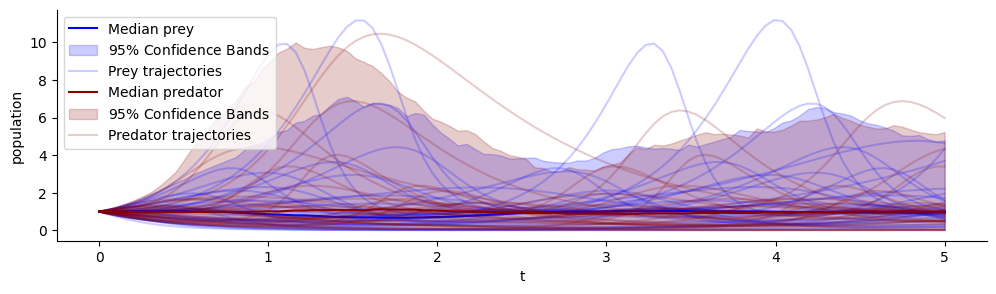

In [8]:
plot_lv_trajectores(samples, ["x", "y"], ["Prey", "Predator"], num_to_plot=30)

Above, we cen see how to access the *prior predictive distribution* of the simulator. The shaded area contains 95% of trajectories at each timestep, additionally we see a few example trajectories.

Predator and prey populations generally oscillate in this model, but the frequency, amplitude, relative lag, and scale varies greatly for different parameters.

The prior predictive distribution should match our expectation of the real world system of interest before we take into account concrete observed population counts.
Here, we see the prior implies population magnitudes to oscillate (mostly) below 6.

## Basic hand crafted summary statistics

Ultimately, we want to learn maximally informative summary statistics jointly with an amortized posterior approximation, but hand crafted summary statistics have the benefit of being interpretable and fast to compute. Oftentimes, there are a few natural and established statistics for a particular modality of raw data. Domain experts are likely to have made significant progress in finding closed form expressions or algorithms for informative summaries.

Compared to the *sufficient summary statistics*, we can expect there to be less posterior contraction.

Still, we can reasonably expect that oscillation period, mean, (log) variance, autocorrelation at different lags of both trajectories, and the cross correlation between the two trajectories are highly informative when taken together as summary statistics.

To compute the expert statistics we can append the `expert_stats` function to the `simulator` object.

In [9]:
simulator = bf.make_simulator([prior, ecology_model, observation_model, expert_stats])

In [10]:
samples_with_expert_stats = simulator.sample(3)
keras.tree.map_structure(keras.ops.shape, samples_with_expert_stats)

{'alpha': (3, 1),
 'beta': (3, 1),
 'gamma': (3, 1),
 'delta': (3, 1),
 'x': (3, 100),
 'y': (3, 100),
 't': (3, 100),
 'observed_x': (3, 10),
 'observed_y': (3, 10),
 'observed_t': (3, 10),
 'means': (3, 2),
 'log_vars': (3, 2),
 'auto_corrs': (3, 4),
 'cross_corr': (3, 1),
 'period': (3, 1)}

In [11]:
training_data = simulator.sample(5000)
validation_data = simulator.sample(300)

## Posterior Approximation with Hand-Crafted Summary Statistics


### Inference Network


Flow Matching is a technique for training neural ODEs (ordinary differential equations) to learn continuous-time dynamics that transform a simple base distribution (e.g., a Gaussian) into a target distribution (e.g., a posterior over simulator parameters). It can be seen as a reparameterization of score-based diffusion models.

At its core, Flow Matching learns a velocity field $\mathbf{v}_\theta(\theta; y, t)$ such that trajectories starting from the base distribution transform into samples from the target distribution over a fixed time interval (typically $t \in [0, 1]$).

In [12]:
flow_matching = bf.networks.FlowMatching()

### Adapter

TODO: Explain

In [13]:
par_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]

adapter = (
    bf.adapters.Adapter()

    # convert from numpy's default float64 to deep learning friendly float32
    .convert_dtype("float64", "float32")

    # drop unobserved full trajectories and raw observations
    .drop(["x", "y", "t", "observed_x", "observed_y", "observed_t"])
    
    # standardize hand-crafted statistics and parameters to zero mean and unit variance
    # running means and stds will be learned on the fly
    .standardize()
    
    # rename the variables to match the required approximator inputs
    .concatenate(["alpha", "beta", "gamma", "delta"], into="inference_variables")
    .concatenate(["means", "log_vars", "auto_corrs", "cross_corr", "period"], into="inference_conditions")

)
adapter

Adapter([0: ConvertDType -> 1: Drop(['x', 'y', 't', 'observed_x', 'observed_y', 'observed_t']) -> 2: Standardize -> 3: Concatenate(['alpha', 'beta', 'gamma', 'delta'] -> 'inference_variables') -> 4: Concatenate(['means', 'log_vars', 'auto_corrs', 'cross_corr', 'period'] -> 'inference_conditions')])

### Workflow and Training

In [14]:
flow_matching_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=flow_matching,
)

In [15]:
epochs = 50
batch_size = 32

In [16]:
history = flow_matching_workflow.fit_offline(
    data=training_data, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 10.1079 - loss/inference_loss: 10.1079 - val_loss: 2.3696 - val_loss/inference_loss: 2.3696
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3387 - loss/inference_loss: 2.3387 - val_loss: 1.2866 - val_loss/inference_loss: 1.2866
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4052 - loss/inference_loss: 1.4052 - val_loss: 0.8287 - val_loss/inference_loss: 0.8287
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1163 - loss/inference_loss: 1.1163 - val_loss: 0.6424 - val_loss/inference_loss: 0.6424
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9669 - loss/inference_loss: 0.9669 - val_loss: 1.0816 - val_loss/inference_loss: 1.0816
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8913 - loss/inference_loss: 0.8913 - val_loss: 0.8646 - val_loss/inference_loss: 0.8646
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8132 - loss/inference_loss: 0.8132 

### Diagnostics and Sampling

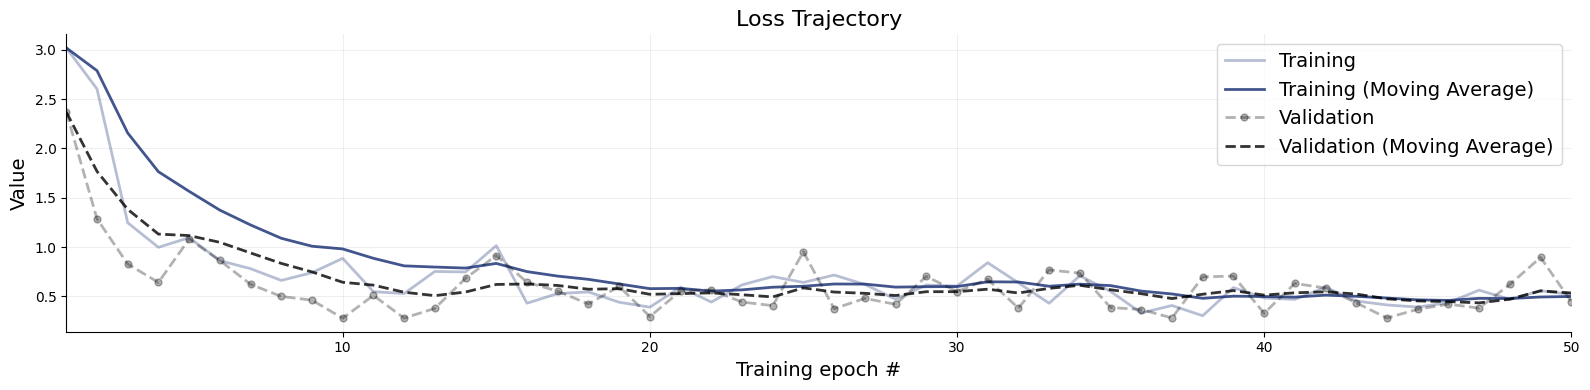

In [17]:
f = bf.diagnostics.loss(history)

In [18]:
# Set the number of posterior draws you want to get
num_samples = 100

# Obtain posterior draws with the sample method
post_draws = flow_matching_workflow.sample(conditions=validation_data, num_samples=num_samples)

Quickly training a point inference network 

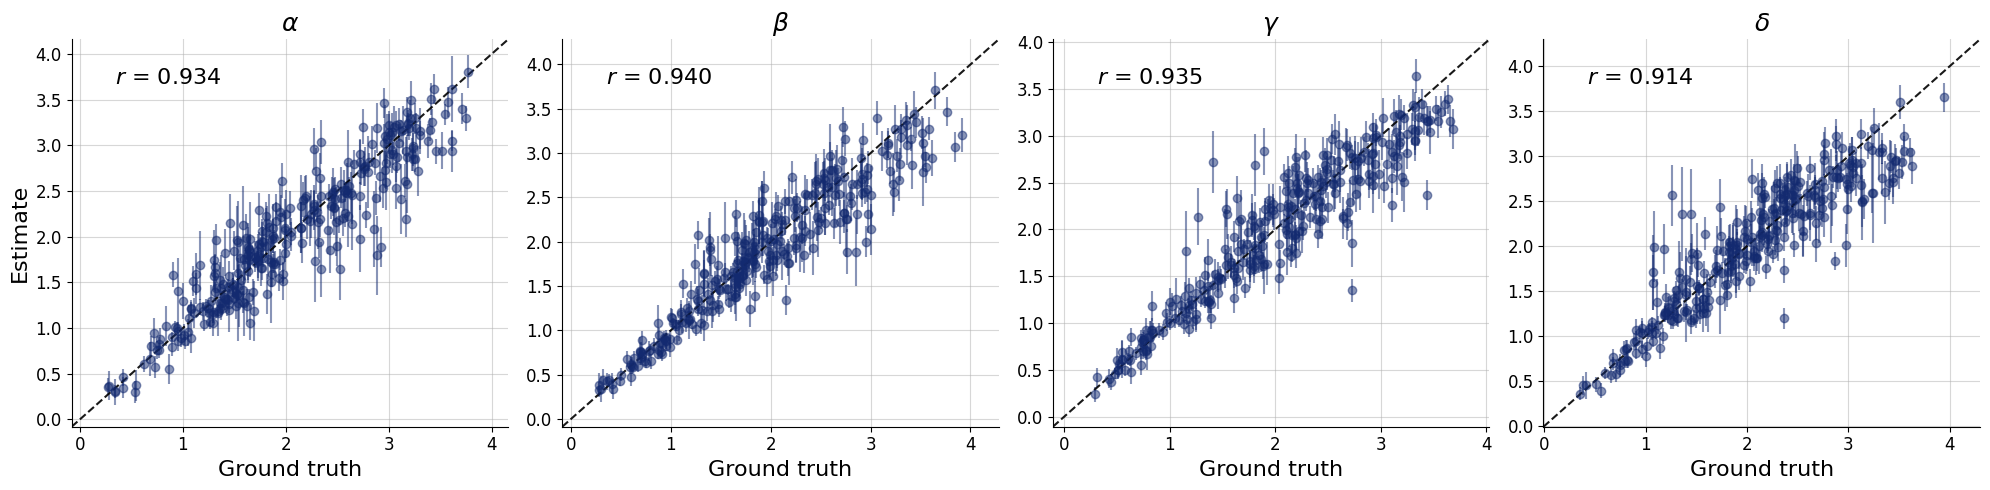

In [19]:
fig = bf.diagnostics.plots.recovery(estimates=post_draws, targets=validation_data, variable_names=par_names)

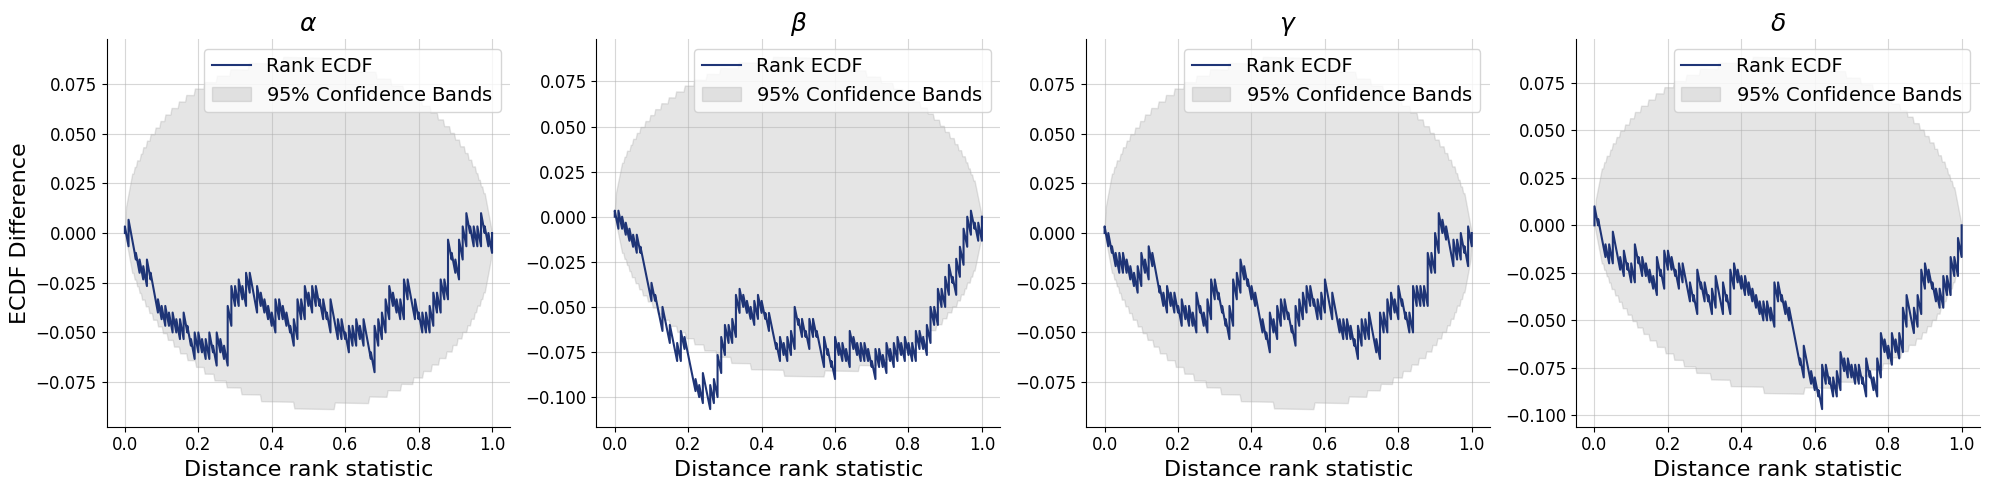

In [20]:
fig = bf.diagnostics.plots.calibration_ecdf(
    estimates=post_draws, 
    targets=validation_data,
    variable_names=par_names,
    difference=True,
    rank_type="distance"
)

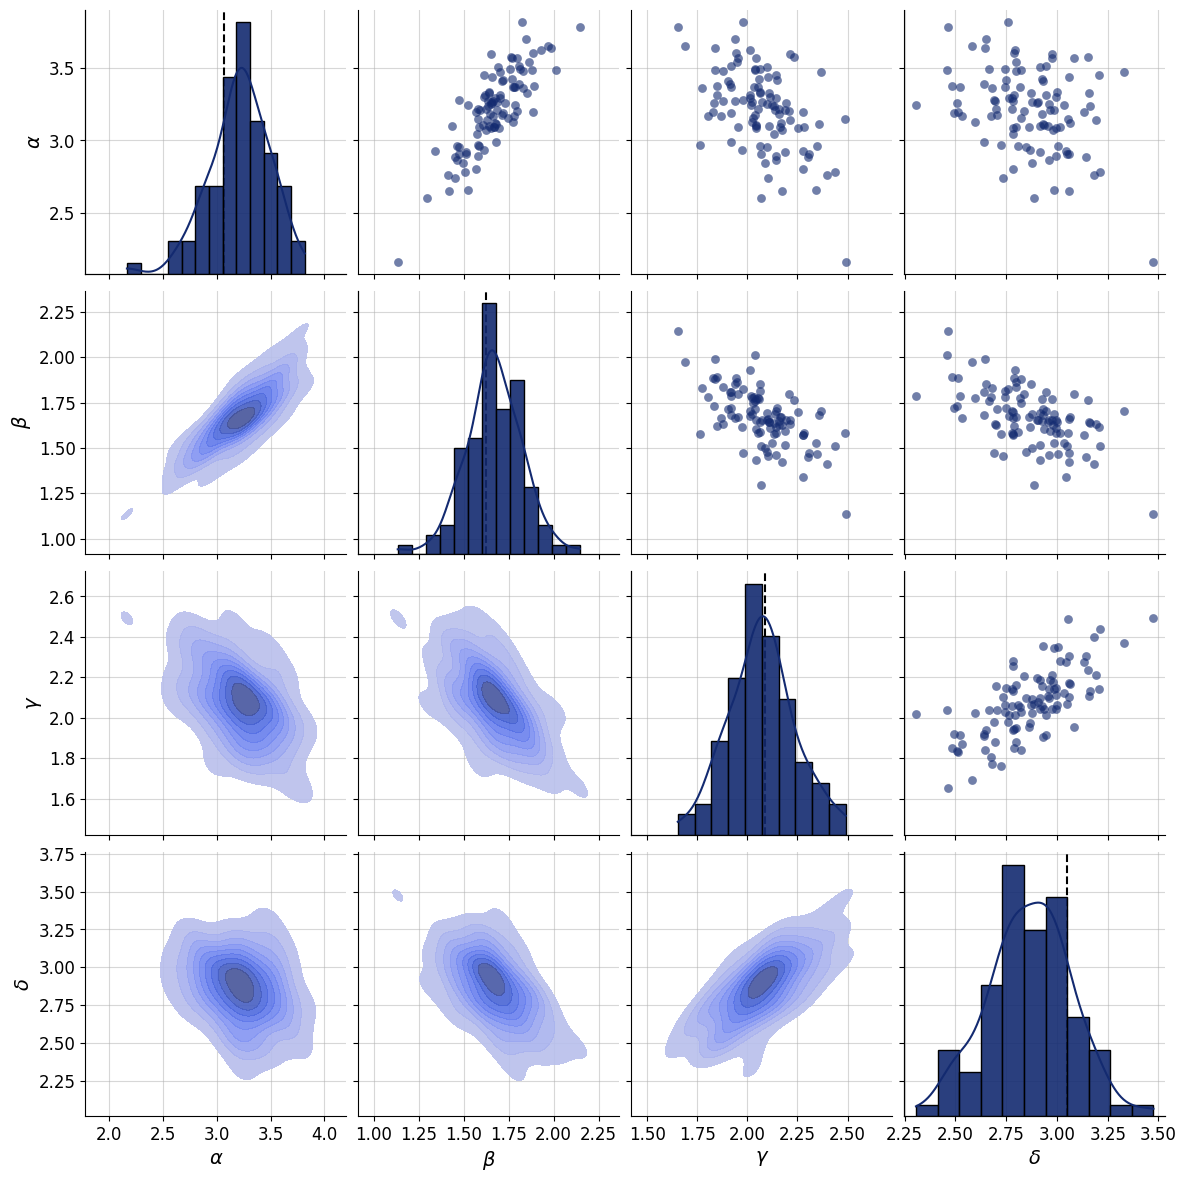

In [21]:
g = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=validation_data,
    dataset_id=0,
    variable_names=par_names,
)

We uncovered a strong correlation between parameters. TODO - Explain why problematic

In [22]:
list_of_resimulations = []
for sample_id in range(num_samples):
    one_post_sample = offline_posterior_sampler(post_draws, dataset_id, sample_id)
    list_of_resimulations.append(ecology_model(t_span=[0,20], **one_post_sample))
resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)

observations = take_dataset(val_sims, dataset_id)

plot_lv_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.xlim(0,5)
plt.title("Trajectories from posterior predictive distribution");

NameError: name 'offline_posterior_sampler' is not defined

In [23]:
plot_lv_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.title("Posterior predictive forecast")
plt.axvline(5, color="grey", linestyle=":");

NameError: name 'resimulation_samples' is not defined

Estimating the correlation of posterior samples has constrained the posterior predictive forecast uncertainty considerably!

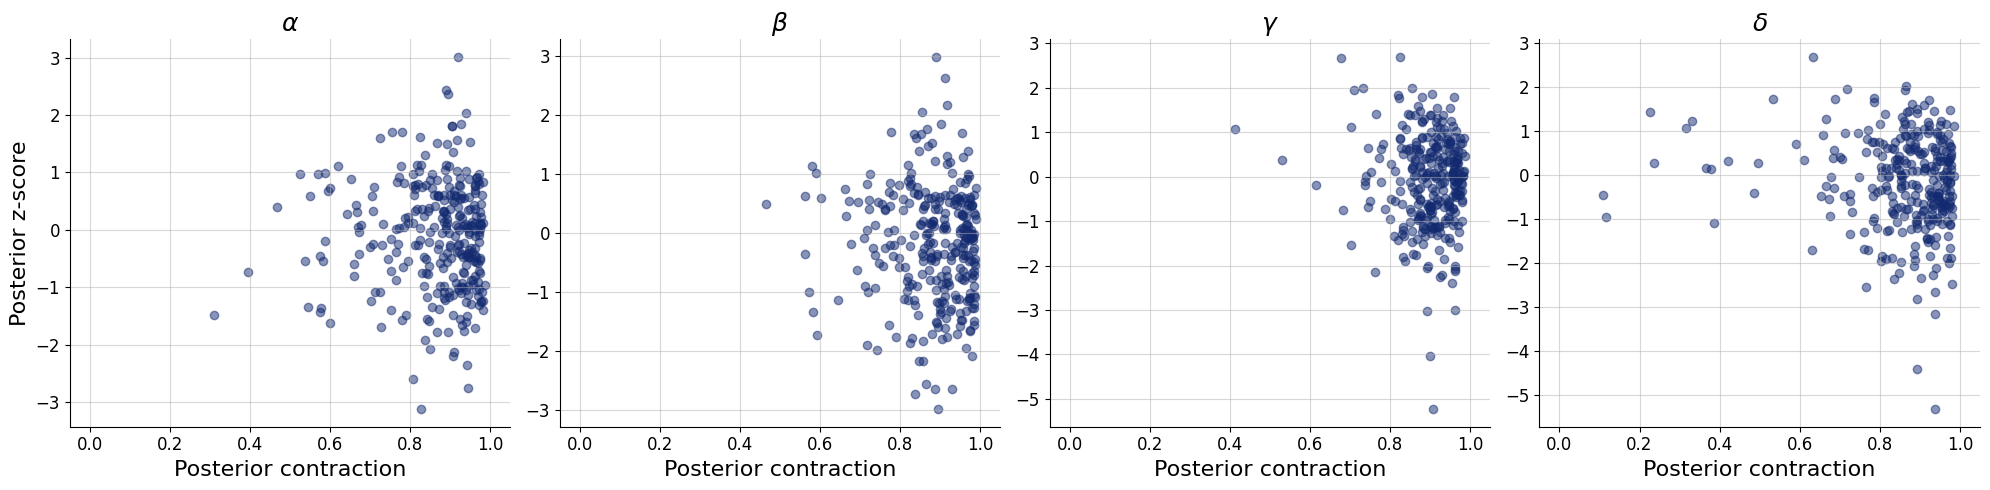

In [25]:
fig = bf.diagnostics.plots.z_score_contraction(
    estimates=post_draws, 
    targets=validation_data,
    variable_names=par_names
)

## End-To-End Learning of Summary Statistics

In [26]:
inference_network = bf.networks.FlowMatching()

summary_network = bf.networks.TimeSeriesNetwork()

In [28]:
e2e_adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .drop(["x", "y", "t"])
    .drop(["means", "log_vars", "auto_corrs", "cross_corr", "period"])
    .as_time_series(["observed_x", "observed_y", "observed_t"])
    .concatenate(["alpha", "beta", "gamma", "delta"], into="inference_variables")
    .concatenate(["observed_x", "observed_y", "observed_t"], into="summary_variables")
    .standardize(include=["inference_variables", "summary_variables"])
)
e2e_adapter

Adapter([0: ConvertDType -> 1: Drop(['x', 'y', 't']) -> 2: Drop(['means', 'log_vars', 'auto_corrs', 'cross_corr', 'period']) -> 3: AsTimeSeries -> 4: Concatenate(['alpha', 'beta', 'gamma', 'delta'] -> 'inference_variables') -> 5: Concatenate(['observed_x', 'observed_y', 'observed_t'] -> 'summary_variables') -> 6: Standardize(include=['inference_variables', 'summary_variables'])])

In [29]:
e2e_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=e2e_adapter,
    summary_network=summary_network,
    inference_network=inference_network
)

In [31]:
%%time
history = e2e_workflow.fit_offline(
    data=training_data, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 2.1897 - loss/inference_loss: 2.1897 - val_loss: 1.4692 - val_loss/inference_loss: 1.4692
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.3641 - loss/inference_loss: 1.3641 - val_loss: 0.7364 - val_loss/inference_loss: 0.7364
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1745 - loss/inference_loss: 1.1745 - val_loss: 0.6751 - val_loss/inference_loss: 0.6751
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0563 - loss/inference_loss: 1.0563 - val_loss: 1.2880 - val_loss/inference_loss: 1.2880
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9750 - loss/inference_loss: 0.9750 - val_loss: 0.9493 - val_loss/inference_loss: 0.9493
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9083 - loss/inference_loss: 0.9083 - val_loss: 0.4944 - val_loss/inference_loss: 0.4944
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8873 - loss/inference_loss: 0.8

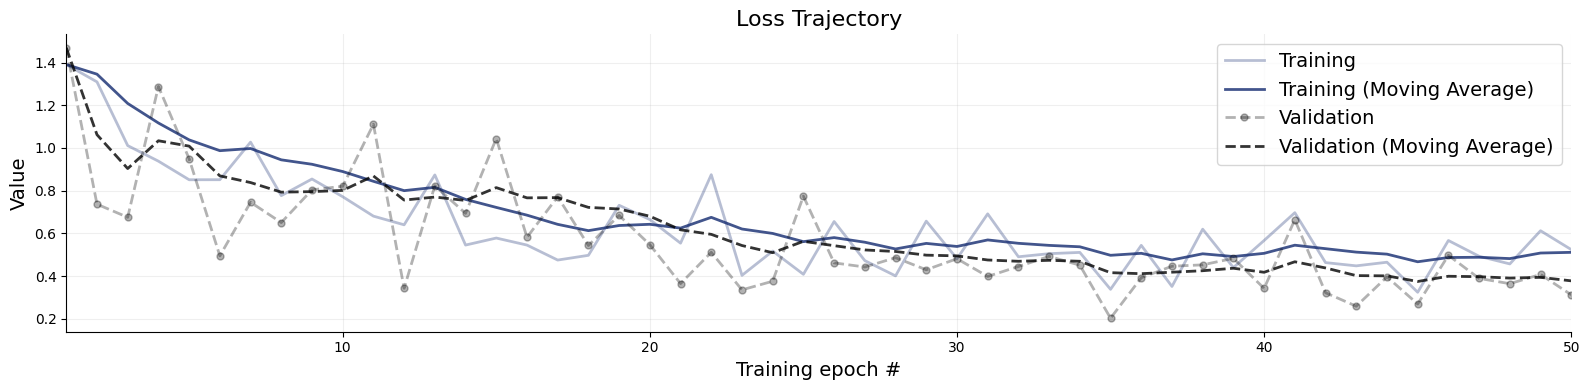

In [32]:
f = bf.diagnostics.loss(history)

Note, that the loss is lower since we are learning summary statistics simultaneously. How does this translate to visual diagnostics? We can check them again by sampling the posteriors of validation simulations not seen in training.

In [35]:
%%time
# Set the number of posterior draws you want to get
num_samples = 100

# Obtain posterior draws with the sample method
post_draws = e2e_workflow.sample(conditions=validation_data, num_samples=num_samples)

CPU times: total: 1min 20s
Wall time: 8.49 s


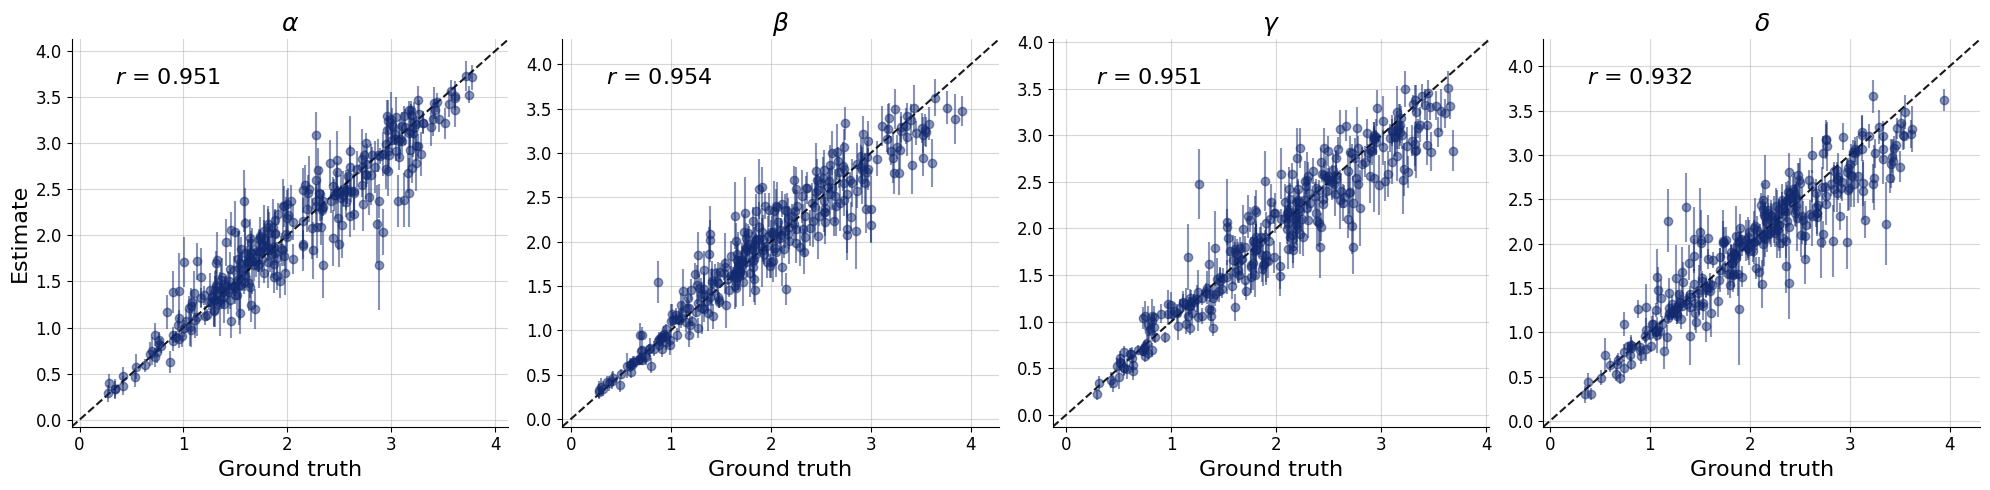

In [36]:
f = bf.diagnostics.plots.recovery(
    estimates=post_draws, 
    targets=validation_data,
    variable_names=par_names
)

In [ ]:
f = bf.diagnostics.plots.calibration_ecdf(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names,
    difference=True,
    rank_type="distance"
)

In [ ]:
g = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=val_sims,
    dataset_id=dataset_id,
    variable_names=par_names,
)

Since the conditions changed now that we learn summaries of observations simultaneously to fitting the inference network, it is not surprising that posteriors seem to be shifted. You can compare how the new posterior samples relate to the dotted quantile estimates.

Neither expert-crafted nor jointly learnt statistics are guaranteed to be highly informative. However, to get to the global minimum of the training loss, the statistics need to be maximally informative. If architecture, training data and optimizer are well chosen, learnt summary statistics regularly outperform hand-crafted statistics.

In [ ]:
list_of_resimulations = []
for sample_id in range(num_samples):
    one_post_sample = offline_posterior_sampler(post_draws, dataset_id, sample_id)
    list_of_resimulations.append(ecology_model(t_span=[0,20], **one_post_sample))
resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)

observations = take_dataset(val_sims, dataset_id)

plot_lv_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.xlim(0,5)
plt.title("Trajectories from posterior predictive distribution");

In [ ]:
plot_lv_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.title("Posterior predictive forecast")
plt.axvline(5, color="grey", linestyle=":");

In [ ]:
f = bf.diagnostics.plots.z_score_contraction(
    estimates=post_draws, 
    targets=validation_data,
    variable_names=par_names
)